#### EngLyser Research
##### Pushkar Sheth | http://phsheth.github.io

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter
import scipy as sp
import matplotlib.pyplot as plt
from pylab import *

from time import perf_counter
import pandas as pd

from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier


%matplotlib qt

C:\Users\phs\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def thetagen(cycles,thetastepsize, forwardoffset):
    thetasingle = np.array(np.arange(0,720,thetastepsize))
    thetarel = np.tile(thetasingle,cycles)
    #thetacum = np.cumsum(thetarel)
    thetacum = np.array(np.arange(0,(720*cycles),thetastepsize))
    #thetacum = thetacum
    return thetasingle, thetarel, thetacum

In [3]:
def gasforcegen(gasforceraw, cycles, thetastepsize,forwardoffset,misfiring):
    thetasingle_deg, thetarel_deg, thetacum_deg = thetagen(cycles,thetastepsize,forwardoffset)
    gasforcerawdata = pd.read_csv(gasforceraw,sep=',',header=None)
    funcakimainterp_gf = sp.interpolate.Akima1DInterpolator(gasforcerawdata[0],gasforcerawdata[1])
    gasforce_theta_deg = funcakimainterp_gf(thetasingle_deg)
    gasforce_theta_deg_cycles = np.tile(gasforce_theta_deg,cycles)
    gasforce_theta_deg_cycles = gasforce_theta_deg_cycles*misfiring
    return gasforce_theta_deg_cycles, thetarel_deg,thetacum_deg

In [4]:
def torquegen(l1_m, l2_m,
              mrod, Izz, lg, mp, engine_speed_rpm, rp_m, 
              gasforcefile, cycles, thetastepsize,forwardoffset,misfiring):
    gasforce_theta_deg_cycles, thetarel_deg,thetacum_deg = gasforcegen(gasforcefile, cycles, thetastepsize,forwardoffset,misfiring)
    #gasforce_theta_deg_cycles = 35*gasforce_theta_deg_cycles/max(gasforce_theta_deg_cycles)
    thetacum_rad = thetacum_deg*np.pi/180
    theta_d = engine_speed_rpm*2*np.pi/60
    theta_dd = 0
    beta = np.arcsin(l1_m*np.sin(thetacum_rad)/l2_m)
    con1 = (1-(np.square(l1_m*np.sin(thetacum_rad)/l2_m)))
    beta_d = (theta_d*l1_m*np.cos(thetacum_rad))/(l2_m*np.sqrt(con1))
    
    a_beta_dd = l1_m*((theta_dd*np.cos(thetacum_rad))-((np.square(theta_d))*np.sin(thetacum_rad)))
    b_beta_dd = l2_m*np.sqrt(con1)
    c_beta_dd = np.square(theta_d)*np.power(l1_m,3)*np.square(np.cos(thetacum_rad))*np.sin(thetacum_rad)
    d_beta_dd = np.power(l2_m,3)*con1
    beta_dd= (a_beta_dd/b_beta_dd)+(c_beta_dd/d_beta_dd)

    a_vpis = (l1_m*theta_d*np.sin(thetacum_rad))
    b_vpis = (np.square(l1_m)*theta_d*np.sin(2*thetacum_rad))
    c_vpis = 2*l2_m*np.sqrt(con1)
    vpis = -a_vpis-(b_vpis/c_vpis)
    
    a_arx = l1_m*theta_dd*np.sin(thetacum_rad)
    b_arx = l1_m*(np.square(theta_d))*np.cos(thetacum_rad)
    c_arx = theta_dd*lg*np.square(l1_m)*np.sin(2*thetacum_rad)
    d_arx = 2*np.square(l2_m)*np.sqrt(con1)
    e_arx = np.square(l2_m)*(2*con1)
    f_arx = np.square(theta_d*l1_m)*lg
    g_arx = 2*np.cos(2*thetacum_rad)*np.sqrt(con1)
    h_arx = np.square(l1_m*np.sin(2*thetacum_rad))
    i_arx = 2*np.square(l2_m)*np.sqrt(con1)
    arx = -a_arx-b_arx-(c_arx/d_arx)-(1/e_arx)*f_arx*(g_arx+(h_arx/i_arx))
    
    a_ary = l1_m*theta_dd*np.cos(thetacum_rad)
    b_ary = l1_m*np.square(theta_d)*np.sin(thetacum_rad)
    c_ary = lg*l1_m*theta_dd*np.cos(thetacum_rad)/l2_m
    d_ary = lg*l1_m*theta_d*np.sin(thetacum_rad)/l2_m
    ary = a_ary - b_ary - c_ary+d_ary
    
    a_apx = l1_m*theta_dd*np.sin(thetacum_rad)
    b_apx = l1_m*(np.square(theta_d))*np.cos(thetacum_rad)
    c_apx = theta_dd*np.square(l1_m)*np.sin(2*thetacum_rad)
    d_apx = 2*l2_m*np.sqrt(con1)
    e_apx = l2_m*(2*con1)
    f_apx = np.square(theta_d*l1_m)
    g_apx = 2*np.cos(2*thetacum_rad)*np.sqrt(con1)
    h_apx = np.square(l1_m*np.sin(2*thetacum_rad))
    i_apx = 2*np.square(l2_m)*np.sqrt(con1)
    apx = -a_apx-b_apx-(c_apx/d_apx)-(1/e_apx)*f_apx*(g_apx+(h_apx/i_apx))
    
    fpx = (mp*apx)+((np.pi)*np.square(rp_m)*gasforce_theta_deg_cycles*0.1*1000000/4)
    
    fax = mrod*arx+fpx
    fay = (1/l2_m)*(((Izz*beta_dd-(fax*lg-fpx*(l2_m-lg)*np.sin(beta)))/np.cos(beta))+mrod*ary*(l2_m-lg))
    
    fx = fax*np.cos(thetacum_rad)+fay*np.sin(thetacum_rad)
    fy = fay*np.cos(thetacum_rad)-fax*np.sin(thetacum_rad)
    #forwardoffset = forwardoffset*np.pi/180
    #thetacum_rad = thetacum_rad
    rpm2radpersec = 6*sp.pi/180
    omega1_radpsec = engine_speed_rpm*rpm2radpersec
    time = thetacum_rad/omega1_radpsec
    torque = -fy*l1_m*1000
    forwardoffset_rad = forwardoffset*np.pi/180
    time_offset = forwardoffset_rad/omega1_radpsec
    offsetindex = (np.where(time == time_offset))
    torque = np.roll(torque,offsetindex[0][0])
    return torque, time, thetacum_deg

In [5]:
fy_1, time_1, theta_1 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,0,1)
fy_5, time_5, theta_5 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,90,1)
fy_4, time_4, theta_4 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,180,1)
fy_8, time_8, theta_8 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,270,1)
fy_6, time_6, theta_6 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,360,1)
fy_3, time_3, theta_3 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,450,1)
fy_7, time_7, theta_7 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,540,1)
fy_2, time_2, theta_2 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,630,1)

In [6]:
fy_1 = fy_1 + np.random.normal(0,((((max(fy_1))-(min(fy_1)))/2))*0.01,len(fy_1))
fy_5 = fy_5 + np.random.normal(0,((((max(fy_5))-(min(fy_5)))/2))*0.01,len(fy_5))
fy_4 = fy_4 + np.random.normal(0,((((max(fy_4))-(min(fy_4)))/2))*0.01,len(fy_4))
fy_8 = fy_8 + np.random.normal(0,((((max(fy_8))-(min(fy_8)))/2))*0.01,len(fy_8))
fy_6 = fy_6 + np.random.normal(0,((((max(fy_6))-(min(fy_6)))/2))*0.01,len(fy_6))
fy_3 = fy_3 + np.random.normal(0,((((max(fy_3))-(min(fy_3)))/2))*0.01,len(fy_3))
fy_7 = fy_7 + np.random.normal(0,((((max(fy_7))-(min(fy_7)))/2))*0.01,len(fy_7))
fy_2 = fy_2 + np.random.normal(0,((((max(fy_2))-(min(fy_2)))/2))*0.01,len(fy_2))

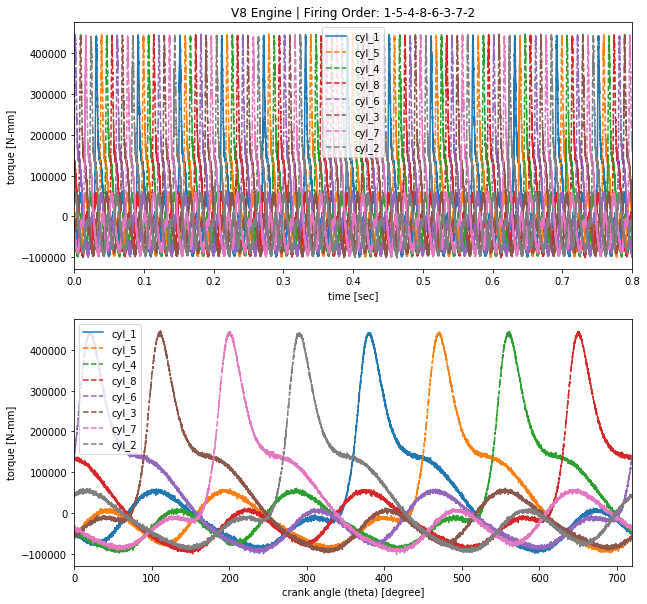

In [7]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.subplot(2,1,1)

plt.plot(time_1,fy_1,label='cyl_1')
plt.plot(time_1,fy_5,"--",label='cyl_5')
plt.plot(time_1,fy_4,"--",label='cyl_4')
plt.plot(time_1,fy_8,"--",label='cyl_8')
plt.plot(time_1,fy_6,"--",label='cyl_6')
plt.plot(time_1,fy_3,"--",label='cyl_3')
plt.plot(time_1,fy_7,"--",label='cyl_7')
plt.plot(time_1,fy_2,"--",label='cyl_2')
plt.legend()
plt.xlabel("time [sec]")
plt.ylabel("torque [N-mm]")
plt.xlim(0,0.8)
plt.title("V8 Engine | Firing Order: 1-5-4-8-6-3-7-2")

plt.subplot(2,1,2)
plt.plot(theta_1,fy_1,label='cyl_1')
plt.plot(theta_1,fy_5,"--",label='cyl_5')
plt.plot(theta_1,fy_4,"--",label='cyl_4')
plt.plot(theta_1,fy_8,"--",label='cyl_8')
plt.plot(theta_1,fy_6,"--",label='cyl_6')
plt.plot(theta_1,fy_3,"--",label='cyl_3')
plt.plot(theta_1,fy_7,"--",label='cyl_7')
plt.plot(theta_1,fy_2,"--",label='cyl_2')
plt.legend(loc = 'upper left')
plt.xlim(0,720)
plt.xlabel("crank angle (theta) [degree]")
plt.ylabel("torque [N-mm]")


plt.show()

In [8]:
torque_cylnom = fy_1+fy_5+fy_4+fy_8+fy_6+fy_3+fy_7+fy_2

In [9]:

#Vectorised Code
def eval_freqfft_vect(time_sec, vibr):
    datalength_fft = len(time_sec)
    datalengthby2 = int(datalength_fft/2)
    timeavgcalc = np.array([], dtype = float64)
    time_sec_i = time_sec[1:]
    time_sec_i_1 = time_sec[:-1]
    timeavgcalc = time_sec_i - time_sec_i_1
    sigint_avg = np.mean(timeavgcalc)
    siginf = 1/(datalength_fft*sigint_avg)
    freqhztemp = np.arange(0,datalength_fft,dtype = float64)
    freqhz = freqhztemp*siginf
    freqhz = freqhz[0:datalengthby2]
    vibr_fft = np.abs(fft(vibr,axis = -1))
    vibr_fft = ((vibr_fft[0:datalengthby2])/datalength_fft)*2
    return freqhz,vibr_fft

In [10]:
fy_1_mf, time_1_mf, theta_1_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,0,0.1)
fy_5_mf, time_5_mf, theta_5_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,90,0.1)
fy_4_mf, time_4_mf, theta_4_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,180,0.1)
fy_8_mf, time_8_mf, theta_8_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,270,0.1)
fy_6_mf, time_6_mf, theta_6_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,360,0.1)
fy_3_mf, time_3_mf, theta_3_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,450,0.1)
fy_7_mf, time_7_mf, theta_7_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,540,0.1)
fy_2_mf, time_2_mf, theta_2_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,630,0.1)

In [11]:
fy_1_mf = fy_1_mf + np.random.normal(0,((((max(fy_1_mf))-(min(fy_1_mf)))/2))*0.01,len(fy_1_mf))
fy_5_mf = fy_5_mf + np.random.normal(0,((((max(fy_5_mf))-(min(fy_5_mf)))/2))*0.01,len(fy_5_mf))
fy_4_mf = fy_4_mf + np.random.normal(0,((((max(fy_4_mf))-(min(fy_4_mf)))/2))*0.01,len(fy_4_mf))
fy_8_mf = fy_8_mf + np.random.normal(0,((((max(fy_8_mf))-(min(fy_8_mf)))/2))*0.01,len(fy_8_mf))
fy_6_mf = fy_6_mf + np.random.normal(0,((((max(fy_6_mf))-(min(fy_6_mf)))/2))*0.01,len(fy_6_mf))
fy_3_mf = fy_3_mf + np.random.normal(0,((((max(fy_3_mf))-(min(fy_3_mf)))/2))*0.01,len(fy_3_mf))
fy_7_mf = fy_7_mf + np.random.normal(0,((((max(fy_7_mf))-(min(fy_7_mf)))/2))*0.01,len(fy_7_mf))
fy_2_mf = fy_2_mf + np.random.normal(0,((((max(fy_2_mf))-(min(fy_2_mf)))/2))*0.01,len(fy_2_mf))

In [12]:
torque_cyl1mf = fy_1_mf+fy_5   +fy_4   +fy_8   +fy_6   +fy_3   +fy_7   +fy_2
torque_cyl5mf = fy_1   +fy_5_mf+fy_4   +fy_8   +fy_6   +fy_3   +fy_7   +fy_2
torque_cyl4mf = fy_1   +fy_5   +fy_4_mf+fy_8   +fy_6   +fy_3   +fy_7   +fy_2
torque_cyl8mf = fy_1   +fy_5   +fy_4   +fy_8_mf+fy_6   +fy_3   +fy_7   +fy_2
torque_cyl6mf = fy_1   +fy_5   +fy_4   +fy_8   +fy_6_mf+fy_3   +fy_7   +fy_2
torque_cyl3mf = fy_1   +fy_5   +fy_4   +fy_8   +fy_6   +fy_3_mf+fy_7   +fy_2
torque_cyl7mf = fy_1   +fy_5   +fy_4   +fy_8   +fy_6   +fy_3   +fy_7_mf+fy_2
torque_cyl2mf = fy_1   +fy_5   +fy_4   +fy_8   +fy_6   +fy_3   +fy_7   +fy_2_mf

torque_cyl1234mf = fy_1_mf+fy_5   +fy_4_mf+fy_8   +fy_6   +fy_3_mf+fy_7   +fy_2_mf
torque_cyl5678mf = fy_1   +fy_5_mf+fy_4   +fy_8_mf+fy_6_mf+fy_3   +fy_7_mf+fy_2

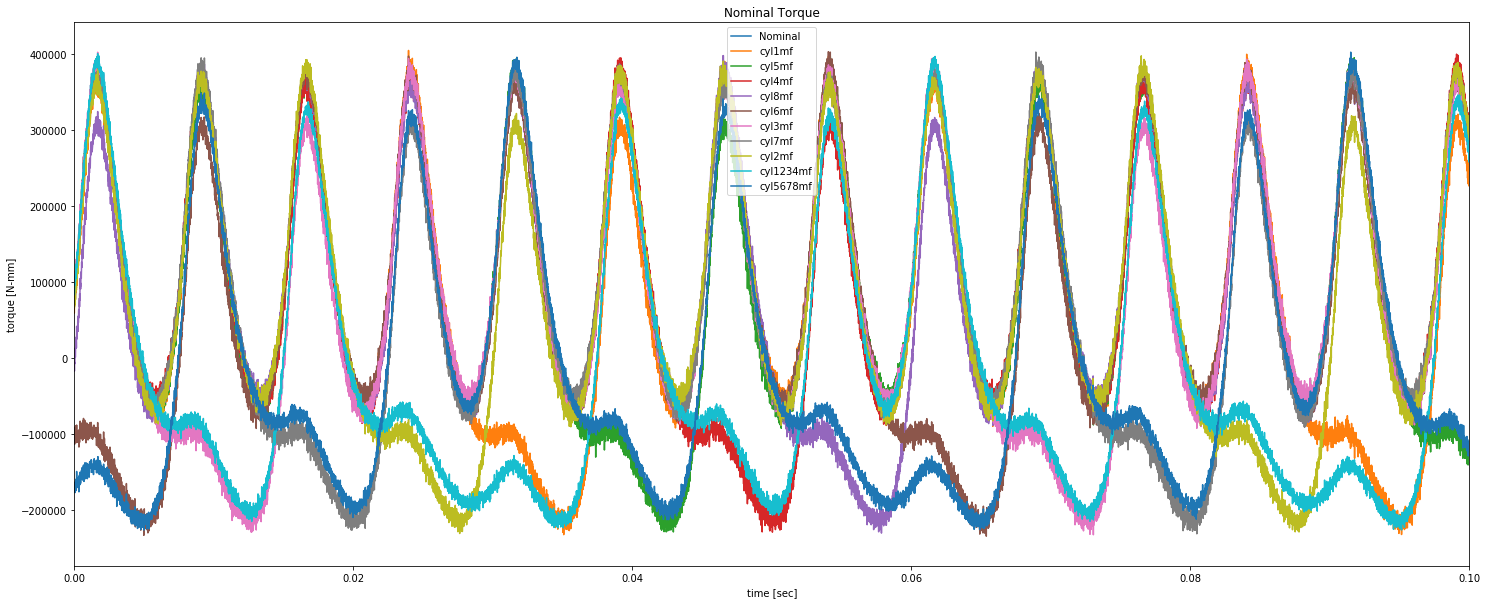

In [13]:
plt.rcParams['figure.figsize'] = [25, 10]

plt.plot(time_1,torque_cylnom, label ="Nominal")
plt.plot(time_1,torque_cyl1mf, label ="cyl1mf")
plt.plot(time_1,torque_cyl5mf, label ="cyl5mf")
plt.plot(time_1,torque_cyl4mf, label ="cyl4mf")
plt.plot(time_1,torque_cyl8mf, label ="cyl8mf")
plt.plot(time_1,torque_cyl6mf, label ="cyl6mf")
plt.plot(time_1,torque_cyl3mf, label ="cyl3mf")
plt.plot(time_1,torque_cyl7mf, label ="cyl7mf")
plt.plot(time_1,torque_cyl2mf, label ="cyl2mf")
plt.plot(time_1,torque_cyl1234mf, label ="cyl1234mf")
plt.plot(time_1,torque_cyl5678mf, label ="cyl5678mf")
plt.xlim(0,0.1)
plt.xlabel("time [sec]")
plt.ylabel("torque [N-mm]")
plt.title("Nominal Torque")
plt.legend()
plt.show()

In [14]:
freq_cylnom,vibr_cylnom = eval_freqfft_vect(time_1,torque_cylnom)
freq_cyl1mf,vibr_cyl1mf = eval_freqfft_vect(time_1,torque_cyl1mf)
freq_cyl5mf,vibr_cyl5mf = eval_freqfft_vect(time_1,torque_cyl5mf)
freq_cyl4mf,vibr_cyl4mf = eval_freqfft_vect(time_1,torque_cyl4mf)
freq_cyl8mf,vibr_cyl8mf = eval_freqfft_vect(time_1,torque_cyl8mf)
freq_cyl6mf,vibr_cyl6mf = eval_freqfft_vect(time_1,torque_cyl6mf)
freq_cyl3mf,vibr_cyl3mf = eval_freqfft_vect(time_1,torque_cyl3mf)
freq_cyl7mf,vibr_cyl7mf = eval_freqfft_vect(time_1,torque_cyl7mf)
freq_cyl2mf,vibr_cyl2mf = eval_freqfft_vect(time_1,torque_cyl2mf)
freq_cyl1234mf,vibr_cyl1234mf = eval_freqfft_vect(time_1,torque_cyl1234mf)
freq_cyl5678mf,vibr_cyl5678mf = eval_freqfft_vect(time_1,torque_cyl5678mf)



C:\Users\phs\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


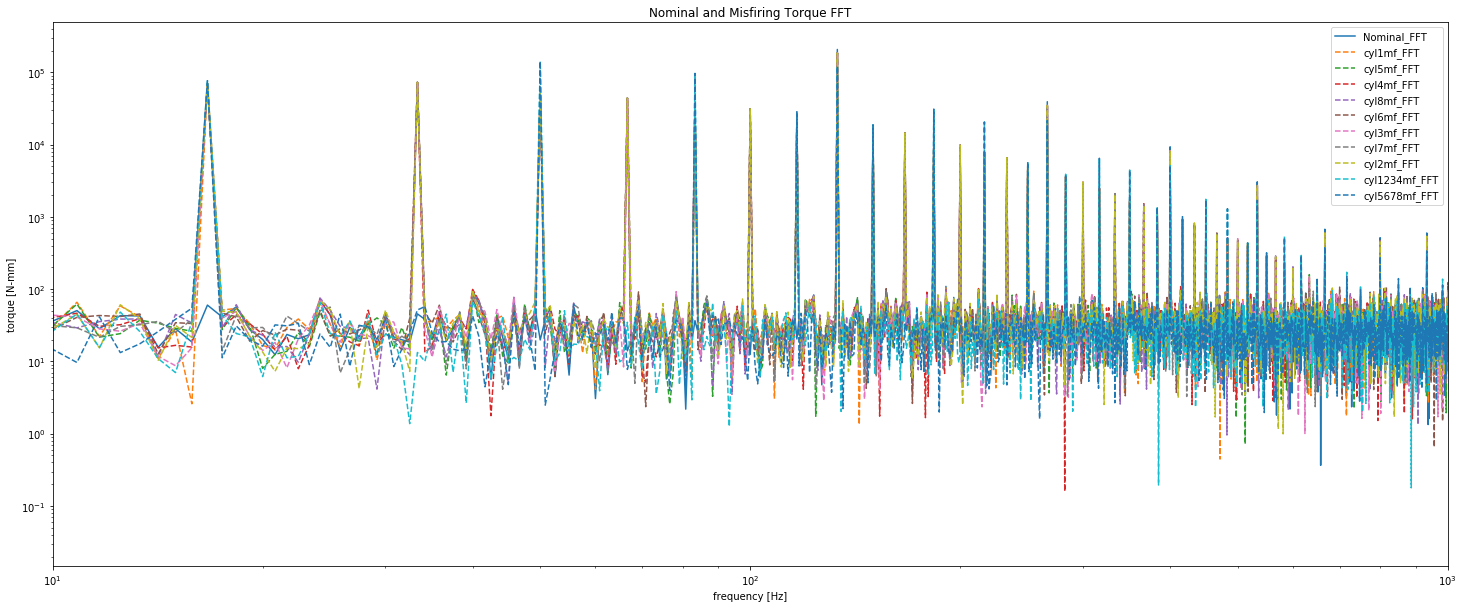

In [15]:
plt.rcParams['figure.figsize'] = [25, 10]

plt.loglog(freq_cylnom,vibr_cylnom, label ="Nominal_FFT")
plt.loglog(freq_cyl1mf,vibr_cyl1mf, "--", label ="cyl1mf_FFT")
plt.loglog(freq_cyl5mf,vibr_cyl5mf, "--", label ="cyl5mf_FFT")
plt.loglog(freq_cyl4mf,vibr_cyl4mf, "--", label ="cyl4mf_FFT")
plt.loglog(freq_cyl8mf,vibr_cyl8mf, "--", label ="cyl8mf_FFT")
plt.loglog(freq_cyl6mf,vibr_cyl6mf, "--", label ="cyl6mf_FFT")
plt.loglog(freq_cyl3mf,vibr_cyl3mf, "--", label ="cyl3mf_FFT")
plt.loglog(freq_cyl7mf,vibr_cyl7mf, "--", label ="cyl7mf_FFT")
plt.loglog(freq_cyl2mf,vibr_cyl2mf, "--", label ="cyl2mf_FFT")
plt.loglog(freq_cyl1234mf,vibr_cyl1234mf, "--", label ="cyl1234mf_FFT")
plt.loglog(freq_cyl5678mf,vibr_cyl5678mf, "--", label ="cyl5678mf_FFT")
plt.xlim(0,0.1)
plt.xlabel("frequency [Hz]")
plt.ylabel("torque [N-mm]")
plt.title("Nominal and Misfiring Torque FFT")
plt.xlim(10,1000)
plt.legend()
plt.show()

In [16]:
x = np.block([[vibr_cylnom],
              [vibr_cyl1mf],
              [vibr_cyl5mf],
              [vibr_cyl4mf],
              [vibr_cyl8mf],
              [vibr_cyl6mf],
              [vibr_cyl3mf],
              [vibr_cyl7mf],
              [vibr_cyl2mf],
              [vibr_cyl1234mf],
              [vibr_cyl5678mf]])
x

array([[2.23241673e+05, 2.79202650e+01, 4.04542217e+01, ...,
        2.08231419e+01, 5.26014479e+01, 3.02755038e+01],
       [1.56039022e+05, 1.65004132e+01, 2.99945221e+01, ...,
        1.58642478e+01, 3.35086911e+01, 2.46764618e+01],
       [1.56051316e+05, 2.72604111e+01, 5.22839449e+01, ...,
        2.10912603e+01, 5.93343814e+01, 3.28153365e+01],
       ...,
       [1.56056795e+05, 1.31066568e+01, 3.58807438e+01, ...,
        1.42385020e+01, 5.76249085e+01, 3.88220634e+01],
       [4.55830830e+04, 7.11757117e+00, 2.36589619e+01, ...,
        2.13351374e+01, 1.55068067e+01, 2.13218689e+01],
       [4.55615949e+04, 3.23037631e+01, 3.67461519e+01, ...,
        4.24785597e+01, 3.02557485e+01, 3.19462236e+01]])

In [17]:
y = np.array([[0,0,0,0,0,0,0,0],
            [1,0,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0],
            [0,0,0,1,0,0,0,0],
            [0,0,0,0,0,0,0,1],
            [0,0,0,0,0,1,0,0],
            [0,0,1,0,0,0,0,0],
            [0,0,0,0,0,0,1,0],
            [0,1,0,0,0,0,0,0],
            [1,1,1,1,0,0,0,0],
            [0,0,0,0,1,1,1,1]], dtype = float)
y

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1.]])

In [18]:
dataframe_np = np.block([x,y])
dataframe_np

array([[2.23241673e+05, 2.79202650e+01, 4.04542217e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.56039022e+05, 1.65004132e+01, 2.99945221e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.56051316e+05, 2.72604111e+01, 5.22839449e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.56056795e+05, 1.31066568e+01, 3.58807438e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.55830830e+04, 7.11757117e+00, 2.36589619e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.55615949e+04, 3.23037631e+01, 3.67461519e+01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [19]:
v8_df = pd.DataFrame(dataframe_np)

In [20]:
v8_df

,0,1,2,3,4,5,6,7,8,9,...,71998,71999,72000,72001,72002,72003,72004,72005,72006,72007
0,223241.673379,27.920265,40.454222,38.577494,31.454955,21.974644,41.906531,25.312031,31.220943,35.050476,...,52.601448,30.275504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,156039.021923,16.500413,29.994522,21.462788,23.216899,8.013311,29.790896,30.427331,31.762044,40.154441,...,33.508691,24.676462,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,156051.316239,27.260411,52.283945,50.965460,34.740589,29.196723,36.134354,26.906773,23.988393,32.808643,...,59.334381,32.815336,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,156006.252088,33.577135,51.707935,34.184639,32.689272,2.567358,37.653995,17.890017,29.738373,30.091681,...,42.557157,30.846610,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,156016.954313,51.236107,28.066409,20.532350,24.736799,33.763403,36.587013,36.621405,16.505697,35.921789,...,50.226792,39.813542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,156053.445989,24.128226,41.126647,45.562884,28.949309,26.979881,47.028900,17.223781,33.095708,28.888700,...,46.550786,27.667197,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,156039.868000,31.586896,20.352098,42.906615,21.382962,17.520216,47.825187,29.040351,25.623662,27.179460,...,39.976402,24.311247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,156041.708647,16.532518,35.511127,32.887327,31.238556,31.093518,46.138010,40.102573,34.619623,23.632288,...,40.254299,21.612559,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,156056.795092,13.106657,35.880744,32.347975,29.783844,25.240881,29.946748,14.091629,34.442959,44.182289,...,57.624908,38.822063,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,45583.083034,7.117571,23.658962,10.312564,6.497067,18.737398,19.570459,17.831660,28.262210,35.974898,...,15.506807,21.321869,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [21]:
x,y

(array([[2.23241673e+05, 2.79202650e+01, 4.04542217e+01, ...,
         2.08231419e+01, 5.26014479e+01, 3.02755038e+01],
        [1.56039022e+05, 1.65004132e+01, 2.99945221e+01, ...,
         1.58642478e+01, 3.35086911e+01, 2.46764618e+01],
        [1.56051316e+05, 2.72604111e+01, 5.22839449e+01, ...,
         2.10912603e+01, 5.93343814e+01, 3.28153365e+01],
        ...,
        [1.56056795e+05, 1.31066568e+01, 3.58807438e+01, ...,
         1.42385020e+01, 5.76249085e+01, 3.88220634e+01],
        [4.55830830e+04, 7.11757117e+00, 2.36589619e+01, ...,
         2.13351374e+01, 1.55068067e+01, 2.13218689e+01],
        [4.55615949e+04, 3.23037631e+01, 3.67461519e+01, ...,
         4.24785597e+01, 3.02557485e+01, 3.19462236e+01]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state=0)
#x_train = np.reshape(x_train, (-1,1))
#x_test = np.reshape(x_test, (-1,1))
#y_train = np.reshape(y_train, (-1,1))
#y_test = np.reshape(y_test, (-1,1))

In [23]:
np.shape(x_train), np.shape(y_train)

((9, 72000), (9, 8))

In [24]:
np.shape(x_test), np.shape(y_test )

((2, 72000), (2, 8))

In [25]:
from sklearn.svm import SVC
classifier = RandomForestClassifier(n_jobs=2, random_state = 0 )
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
y_pred = classifier.predict(x_test)

In [27]:
y_pred,y_test

(array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0.]]))